In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchtext
import torch.nn as nn
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torch.utils.data import  TensorDataset, DataLoader
from collections import Counter
from torchinfo import summary
from sklearn.metrics import confusion_matrix

# download or read from cache IMDb data
train_data = list(IMDB(split='train'))
test_data = list(IMDB(split='test'))

# download or read from cache word embeddings
vectors = torchtext.vocab.GloVe(name='6B', dim=50, max_vectors=100_000)

# build the vocabulary---all words in training data
tokenizer = get_tokenizer('basic_english')
counter = Counter()
for (label, line) in train_data:
    counter.update(tokenizer(line))
counter = dict(counter.most_common())    
vocab = torchtext.vocab.vocab(counter, min_freq=10, specials=('<PAD>', '<unk>'))
vocab.set_default_index(vocab['<unk>'])# if encounter a word that it didn't know, set as '<unk>'

# takes in a review (string), returns a vector of indices (maxlength T)
def text_transform(x, T=256):
    indices = [vocab[token] for token in tokenizer(x)]
    return indices[:256] if len(indices) > T else indices + [0] * (T-len(indices)) # if the length of review over 256, take the first 256 words, else padding with '<PAD>' unless it reach to 256

# takes in the sentiment, returns 1/0 labels (1 for positive review)
def label_transform(x):
    return 1 if x == 2 else 0

# returns X, y tensors from training data
def create_tensors(train_data):
    label_list, text_list = [], []
    for idx, (label, text) in enumerate(train_data):
        label_list.append(label_transform(label))
        processed_text = torch.tensor(text_transform(text))
        text_list.append(processed_text)
    return torch.stack(text_list), torch.tensor(label_list)
def build_embedding(vocab, vectors):
    # loop over all vocab indices, for each get token, get embedding (from token), add it to list
    itos = vocab.get_itos()    # List mapping indices to tokens.
    embed_list = [vectors[tok] for tok in itos]
    return torch.stack(embed_list)



In [2]:
# Create data loaders
X, y = create_tensors(train_data)
Test_X, Test_y = create_tensors(test_data)
train_dataset  = TensorDataset(X, y)
train_loader  = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_dataset = TensorDataset(Test_X, Test_y)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
print("Vocabulary size: ", len(vocab))


Vocabulary size:  20437


In [5]:
# Define the model
class SentimentAnalysisModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(SentimentAnalysisModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)  # 2 classes: positive and negative
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        rdim = 0 if x.ndim == 1 else 1   # if x is a batch, reduction is along dim 1
        x = self.embedding(x)
        x = torch.mean(x, dim=rdim)      # average the embeddings
        #print("x.shape=",x.shape)
        rnn_out, _ = self.rnn(x)
        output = self.fc(rnn_out)
        output=self.sigmoid(output)
        return output
# Hyperparameters
embedding_dim = 100
hidden_dim = 256
batch_size = 64
# Create the model
model = SentimentAnalysisModel(len(vocab), embedding_dim, hidden_dim)

In [6]:
learning_rate = 0.001
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Training loop
num_epochs = 20
train_losses = []
for epoch in range(num_epochs):
    for data in train_loader:
        text, labels = data
        optimizer.zero_grad()
        outputs = model(text)
        outputs=outputs.view(-1)
        #print("outputs=",outputs.shape)
        #print("labels=",labels.shape)
        loss = criterion(outputs.float(), labels.float())
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    train_losses.append(loss.item())



Epoch [1/20], Loss: 0.6513
Epoch [2/20], Loss: 0.5733
Epoch [3/20], Loss: 0.4752
Epoch [4/20], Loss: 0.3919
Epoch [5/20], Loss: 0.3440
Epoch [6/20], Loss: 0.2874
Epoch [7/20], Loss: 0.2581
Epoch [8/20], Loss: 0.2098
Epoch [9/20], Loss: 0.1960
Epoch [10/20], Loss: 0.1963
Epoch [11/20], Loss: 0.1549
Epoch [12/20], Loss: 0.1555
Epoch [13/20], Loss: 0.1970
Epoch [14/20], Loss: 0.1306
Epoch [15/20], Loss: 0.1093
Epoch [16/20], Loss: 0.1272
Epoch [17/20], Loss: 0.1427
Epoch [18/20], Loss: 0.1140
Epoch [19/20], Loss: 0.0739
Epoch [20/20], Loss: 0.0494


Accuracy on test data: 54.95%


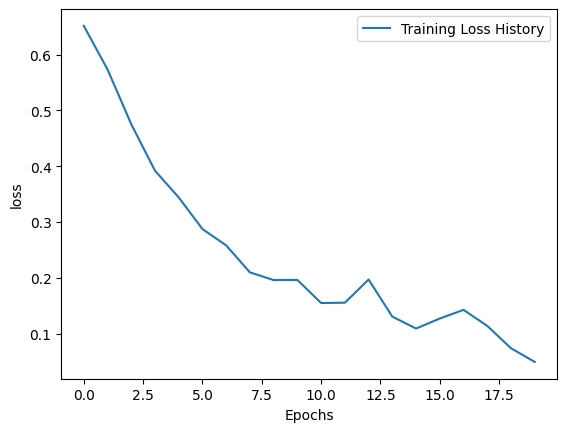

In [7]:
import matplotlib.pyplot as plt
def plotLossHistory(train_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend()
plotLossHistory(train_losses)
# Evaluate the model
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        text, labels = data
        outputs = model(text)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on test data: {accuracy:.2f}%')